## prepare

### clone SOLO code repo

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Install mmdetection
import os
os.chdir('/content/')
os.system('rm -rf mmdetection')
os.system('git clone https://github.com/WXinlong/SOLO.git')
os.chdir('/content/SOLO')
os.makedirs('checkpoints', exist_ok=True)


### requirement

In [ ]:
!sed -i "s/Pillow<=6.2.2/Pillow/g" requirements/runtime.txt

In [ ]:
# 在執行setup.py之前要先把pytorch降板，目前colab預設torch==1.10.0+cu111，這會導致SOLO依賴的mmdet和mmcv出錯
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!yes | pip install -r requirements/build.txt
!yes | pip install "git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI"
!yes | pip install -v -e .  # 可以用以下指令取代 python setup.py develop --user

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-n_qjk4ww
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-n_qjk4ww
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: 

### import module 

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
print(mmcv.__version__)


1.9.0+cu111 True
1.0.0+95f3732
0.2.16
1.9.0+cu111 True
1.0.0+95f3732
0.2.16


### set up hyper-params

In [ ]:
#@title pre-trained model
model_url = "https://cloudstor.aarnet.edu.au/plus/s/HwHys05haPvNyAY/download" #@param {type:"string"}
model_name = 'solov2' #@param {type:"string"}
model_config = 'solov2_light_448_r18_fpn_8gpu_3x.py' #@param {type:"string"}
model_checkpoints = model_config.split('.')[0]+'_model.pth'
# lis = os.listdir(f'/content/SOLO/configs/{model_name}')
# lis

# model_config = [i for i in lis if len(model_checkpoints.split(i.split('.py')[0]))==2][0]

# print('model_name:\n>>', model_name)
print('model_config:\n>>', f'/content/SOLO/configs/{model_name}/{model_config}')
# print('model_checkpoints:\n>>', model_checkpoints)

os.system(f'wget -c {model_url} \
      -O checkpoints/{model_checkpoints}')
os.listdir('/content/SOLO/checkpoints')

model_config:
>> /content/SOLO/configs/solov2/solov2_light_448_r18_fpn_8gpu_3x.py


['solov2_light_448_r18_fpn_8gpu_3x_model.pth']

model_config:
>> /content/SOLO/configs/solov2/solov2_light_448_r18_fpn_8gpu_3x.py


['solov2_light_448_r18_fpn_8gpu_3x_model.pth']

## init_detector

In [ ]:
import warnings

import mmcv
import numpy as np
from mmcv.runner import load_checkpoint

from mmdet.core import get_classes
from mmdet.datasets.pipelines import Compose
from mmdet.models import build_detector

import cv2
from scipy import ndimage

### 補充: read config file example

In [ ]:
config = f'configs/{model_name}/{model_config}'
if isinstance(config, str):
  config = mmcv.Config.fromfile(config)

print('key', config._cfg_dict.keys())
print('MMDetection configs to dict', config._cfg_dict)
print('\n***')

config.model

key dict_keys(['model', 'train_cfg', 'test_cfg', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'optimizer', 'optimizer_config', 'lr_config', 'checkpoint_config', 'log_config', 'total_epochs', 'device_ids', 'dist_params', 'log_level', 'work_dir', 'load_from', 'resume_from', 'workflow'])
MMDetection configs to dict {'model': {'type': 'SOLOv2', 'pretrained': 'torchvision://resnet18', 'backbone': {'type': 'ResNet', 'depth': 18, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'style': 'pytorch'}, 'neck': {'type': 'FPN', 'in_channels': [64, 128, 256, 512], 'out_channels': 256, 'start_level': 0, 'num_outs': 5}, 'bbox_head': {'type': 'SOLOv2Head', 'num_classes': 81, 'in_channels': 256, 'stacked_convs': 2, 'seg_feat_channels': 256, 'strides': [8, 8, 16, 32, 32], 'scale_ranges': ((1, 56), (28, 112), (56, 224), (112, 448), (224, 896)), 'sigma': 0.2, 'num_grids': [40, 36, 24, 16, 12], 'ins_out_channels': 128, 'loss_ins': {'type': 'DiceLos

{'backbone': {'depth': 18,
  'frozen_stages': 1,
  'num_stages': 4,
  'out_indices': (0, 1, 2, 3),
  'style': 'pytorch',
  'type': 'ResNet'},
 'bbox_head': {'in_channels': 256,
  'ins_out_channels': 128,
  'loss_cate': {'alpha': 0.25,
   'gamma': 2.0,
   'loss_weight': 1.0,
   'type': 'FocalLoss',
   'use_sigmoid': True},
  'loss_ins': {'loss_weight': 3.0, 'type': 'DiceLoss', 'use_sigmoid': True},
  'num_classes': 81,
  'num_grids': [40, 36, 24, 16, 12],
  'scale_ranges': ((1, 56), (28, 112), (56, 224), (112, 448), (224, 896)),
  'seg_feat_channels': 256,
  'sigma': 0.2,
  'stacked_convs': 2,
  'strides': [8, 8, 16, 32, 32],
  'type': 'SOLOv2Head'},
 'mask_feat_head': {'end_level': 3,
  'in_channels': 256,
  'norm_cfg': {'num_groups': 32, 'requires_grad': True, 'type': 'GN'},
  'num_classes': 128,
  'out_channels': 128,
  'start_level': 0,
  'type': 'MaskFeatHead'},
 'neck': {'in_channels': [64, 128, 256, 512],
  'num_outs': 5,
  'out_channels': 256,
  'start_level': 0,
  'type': 'FPN'

key dict_keys(['model', 'train_cfg', 'test_cfg', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'optimizer', 'optimizer_config', 'lr_config', 'checkpoint_config', 'log_config', 'total_epochs', 'device_ids', 'dist_params', 'log_level', 'work_dir', 'load_from', 'resume_from', 'workflow'])
MMDetection configs to dict {'model': {'type': 'SOLOv2', 'pretrained': 'torchvision://resnet18', 'backbone': {'type': 'ResNet', 'depth': 18, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'style': 'pytorch'}, 'neck': {'type': 'FPN', 'in_channels': [64, 128, 256, 512], 'out_channels': 256, 'start_level': 0, 'num_outs': 5}, 'bbox_head': {'type': 'SOLOv2Head', 'num_classes': 81, 'in_channels': 256, 'stacked_convs': 2, 'seg_feat_channels': 256, 'strides': [8, 8, 16, 32, 32], 'scale_ranges': ((1, 56), (28, 112), (56, 224), (112, 448), (224, 896)), 'sigma': 0.2, 'num_grids': [40, 36, 24, 16, 12], 'ins_out_channels': 128, 'loss_ins': {'type': 'DiceLos

{'backbone': {'depth': 18,
  'frozen_stages': 1,
  'num_stages': 4,
  'out_indices': (0, 1, 2, 3),
  'style': 'pytorch',
  'type': 'ResNet'},
 'bbox_head': {'in_channels': 256,
  'ins_out_channels': 128,
  'loss_cate': {'alpha': 0.25,
   'gamma': 2.0,
   'loss_weight': 1.0,
   'type': 'FocalLoss',
   'use_sigmoid': True},
  'loss_ins': {'loss_weight': 3.0, 'type': 'DiceLoss', 'use_sigmoid': True},
  'num_classes': 81,
  'num_grids': [40, 36, 24, 16, 12],
  'scale_ranges': ((1, 56), (28, 112), (56, 224), (112, 448), (224, 896)),
  'seg_feat_channels': 256,
  'sigma': 0.2,
  'stacked_convs': 2,
  'strides': [8, 8, 16, 32, 32],
  'type': 'SOLOv2Head'},
 'mask_feat_head': {'end_level': 3,
  'in_channels': 256,
  'norm_cfg': {'num_groups': 32, 'requires_grad': True, 'type': 'GN'},
  'num_classes': 128,
  'out_channels': 128,
  'start_level': 0,
  'type': 'MaskFeatHead'},
 'neck': {'in_channels': [64, 128, 256, 512],
  'num_outs': 5,
  'out_channels': 256,
  'start_level': 0,
  'type': 'FPN'

### init_detector

In [ ]:
def init_detector(config, checkpoint=None, device='cuda:0'):
    """Initialize a detector from config file.

    Args:
        config (str or :obj:`mmcv.Config`): Config file path or the config
            object.
        checkpoint (str, optional): Checkpoint path. If left as None, the model
            will not load any weights.

    Returns:
        nn.Module: The constructed detector.
    """
    if isinstance(config, str):
        config = mmcv.Config.fromfile(config)
    elif not isinstance(config, mmcv.Config):
        raise TypeError('config must be a filename or Config object, '
                        'but got {}'.format(type(config)))
    config.model.pretrained = None
    model = build_detector(config.model, test_cfg=config.test_cfg)
    if checkpoint is not None:
        checkpoint = load_checkpoint(model, checkpoint)
        if 'CLASSES' in checkpoint['meta']:
            model.CLASSES = checkpoint['meta']['CLASSES']
        else:
            warnings.warn('Class names are not saved in the checkpoint\'s '
                          'meta data, use COCO classes by default.')
            model.CLASSES = get_classes('coco')
    model.cfg = config  # save the config in the model for convenience
    model.to(device)
    model.eval()
    return model


In [ ]:
# from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = f'configs/{model_name}/{model_config}'
# config = 'configs/solo/decoupled_solo_light_r50_fpn_3x_coco.py' #@param {type:"string"}

# Setup a checkpoint file to load
checkpoint = f'checkpoints/{model_checkpoints}'
# checkpoint = 'checkpoints/decoupled_solo_light_r50_fpn_3x_coco_20210906_142703-e70e226f.pth' #@param {type:"string"}

# initialize the detector
model = init_detector(config, checkpoint)



## inference_detector

In [ ]:
from mmcv.parallel import collate, scatter
# from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
# from mmcv.ops import RoIPool
import torch
from mmdet.apis import show_result_pyplot

In [ ]:
class LoadImage(object):

    def __call__(self, results):
        if isinstance(results['img'], str):
            results['filename'] = results['img']
        else:
            results['filename'] = None
        img = mmcv.imread(results['img'])
        results['img'] = img
        results['img_shape'] = img.shape
        results['ori_shape'] = img.shape
        return results

### 補充: From cfg to test pipeline

In [ ]:
# cfg = model.cfg
# print(type(cfg))
# cfg.data.test.pipeline[0]

In [ ]:
# device = next(model.parameters()).device  # model device
# print(device) # 模型實際上的位置
# # if isinstance(imgs[0], np.ndarray):
# #     cfg = cfg.copy()
# #     # set loading pipeline type
# cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

# cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
# test_pipeline = Compose(cfg.data.test.pipeline) # 用compose方法把list of dictionarys轉換成mmdetection的方法實例
# type(test_pipeline)

### inference_detector

In [ ]:
def inference_detector(model, img):
    """Inference image(s) with the detector.

    Args:
        model (nn.Module): The loaded detector.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.

    Returns:
        If imgs is a str, a generator will be returned, otherwise return the
        detection results directly.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    test_pipeline = [LoadImage()] + cfg.data.test.pipeline[1:]
    test_pipeline = Compose(test_pipeline)
    # prepare data
    data = dict(img=img)
    data = test_pipeline(data)
    data = scatter(collate([data], samples_per_gpu=1), [device])[0]
    # forward the model
    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result

In [ ]:
from mmdet.apis import show_result_ins

In [ ]:
# test a single image
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor di

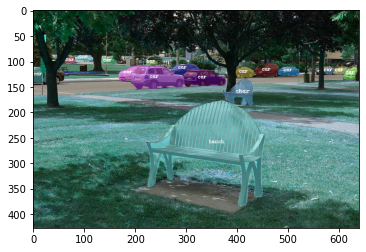

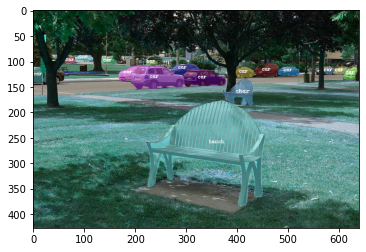

In [ ]:
# show the results
# show_result_pyplot(img, result, model.CLASSES)
import matplotlib.pyplot as plt

image = show_result_ins(img, result, model.CLASSES, score_thr=0.25, out_file=None)
plt.imshow(image)
# image

## 訓練SOLO模型
如果需要客製化自己的資料集，你可以使用labelme來標註資料並轉換到coco-dataset的格式。
你可以用下方文件來學習資料集的建立
- https://colab.research.google.com/drive/1XmIuhu80d80IVjipxVtkxAuvWQmBjAhe#scrollTo=q0pRSgbif7H0

In [ ]:
%cd /content/SOLO
!mkdir data

/content
mkdir: cannot create directory ‘data’: File exists
/content
mkdir: cannot create directory ‘data’: File exists


In [ ]:
# 下載並將 coco_raccoon_dataset 放至 SOLO/data 路徑下

import gdown

url = 'https://drive.google.com/u/3/uc?id=1ojhX7aoeRyjN1CRisIYjJ01gA17pJYl0&export=download'
output = './data/my_dataset.zip'
gdown.download(url, output)
!unzip -o ./data/my_dataset.zip -d ./data

Downloading...
From: https://drive.google.com/u/3/uc?id=1ojhX7aoeRyjN1CRisIYjJ01gA17pJYl0&export=download
To: /content/SOLO/data/my_dataset.zip
100%|██████████| 3.77M/3.77M [00:00<00:00, 72.0MB/s]


Archive:  ./data/my_dataset.zip
  inflating: ./data/my_dataset/train/JPEGImages/1.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/10.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/11.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/12.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/13.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/14.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/15.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/16.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/17.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/18.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/19.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/2.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/20.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/21.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/22.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/23.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/24.jpg  
 

Downloading...
From: https://drive.google.com/u/3/uc?id=1ojhX7aoeRyjN1CRisIYjJ01gA17pJYl0&export=download
To: /content/SOLO/data/my_dataset.zip
100%|██████████| 3.77M/3.77M [00:00<00:00, 75.2MB/s]


Archive:  ./data/my_dataset.zip
  inflating: ./data/my_dataset/train/JPEGImages/1.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/10.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/11.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/12.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/13.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/14.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/15.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/16.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/17.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/18.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/19.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/2.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/20.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/21.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/22.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/23.jpg  
  inflating: ./data/my_dataset/train/JPEGImages/24.jpg  
 

In [ ]:
%%writefile /content/SOLO/mmdet/datasets/my_dataset.py
from .coco import CocoDataset
from .registry import DATASETS
@DATASETS.register_module
class MyDataset(CocoDataset):
    CLASSES = ['null', 'raccoon']

Overwriting /content/SOLO/mmdet/datasets/my_dataset.py
Overwriting /content/SOLO/mmdet/datasets/my_dataset.py


In [ ]:
%%writefile /content/SOLO/mmdet/datasets/__init__.py
from .builder import build_dataset
from .cityscapes import CityscapesDataset
from .coco import CocoDataset
from .custom import CustomDataset
from .dataset_wrappers import ConcatDataset, RepeatDataset
from .loader import DistributedGroupSampler, GroupSampler, build_dataloader
from .registry import DATASETS
from .voc import VOCDataset
from .wider_face import WIDERFaceDataset
from .xml_style import XMLDataset
from .my_dataset import MyDataset # add MyDataset

__all__ = [
    'CustomDataset', 'XMLDataset', 'CocoDataset', 'VOCDataset',
    'CityscapesDataset', 'GroupSampler', 'DistributedGroupSampler',
    'build_dataloader', 'ConcatDataset', 'RepeatDataset', 'WIDERFaceDataset',
    'DATASETS', 'build_dataset', 'MyDataset' # add MyDataset
]

Overwriting /content/SOLO/mmdet/datasets/__init__.py
Overwriting /content/SOLO/mmdet/datasets/__init__.py


修改 configs/solov2/中指定的config檔案

- 更改第20行: num_classes 設定為類別數+1
- 更改第59、60行: dataset_type 和 data_root 路徑
- 更改第97、98、102、103、107、108行: data = dict() 裡 train、- val、test 的 ann_file、img_prefix 路徑
- 可修改 optimizer、learning rate、total_epochs 等超參數，其中 work_dir 為存放訓練模型的路徑

In [ ]:
model_config

'solov2_light_448_r18_fpn_8gpu_3x.py'

In [ ]:
os.system(f'cp -f /content/SOLO/configs/{model_name}/{model_config} /content/SOLO/configs/solov2/my_config.py')
!sed -i '20s/num_classes=81/num_classes=3/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '59s/CocoDataset/MyDataset/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '60s/coco/my_dataset/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '97s/annotations/train/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '97s/instances_train2017.json/annotations.json/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '98s/train2017/train/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '102,108s/annotations/valid/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '102,108s/instances_val2017.json/annotations.json/g' /content/SOLO/configs/solov2/my_config.py
!sed -i '102,108s/val2017/valid/g' /content/SOLO/configs/solov2/my_config.py

# 改變儲存權重的位置
!sed -i "134c work_dir = './work_dirs/my_config'" /content/SOLO/configs/solov2/my_config.py

In [ ]:
!python tools/train.py configs/solov2/my_config.py

2022-03-02 06:35:47,083 - mmdet - INFO - Distributed training: False
2022-03-02 06:35:47,083 - mmdet - INFO - MMDetection Version: 1.0.0+95f3732
2022-03-02 06:35:47,083 - mmdet - INFO - Config:
# model settings
model = dict(
    type='SOLOv2',
    pretrained='torchvision://resnet18',
    backbone=dict(
        type='ResNet',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3), # C2, C3, C4, C5
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[64, 128, 256, 512],
        out_channels=256,
        start_level=0,
        num_outs=5),
    bbox_head=dict(
        type='SOLOv2Head',
        num_classes=3,
        in_channels=256,
        stacked_convs=2,
        seg_feat_channels=256,
        strides=[8, 8, 16, 32, 32],
        scale_ranges=((1, 56), (28, 112), (56, 224), (112, 448), (224, 896)),
        sigma=0.2,
        num_grids=[40, 36, 24, 16, 12],
        ins_out_channels=128,
        loss_ins=dict(
        

In [ ]:
# from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = '/content/SOLO/configs/solov2/my_config.py'
# config = 'configs/solo/decoupled_solo_light_r50_fpn_3x_coco.py' #@param {type:"string"}

# Setup a checkpoint file to load
checkpoint = '/content/SOLO/work_dirs/my_config/latest.pth'
# checkpoint = 'checkpoints/decoupled_solo_light_r50_fpn_3x_coco_20210906_142703-e70e226f.pth' #@param {type:"string"}

# initialize the detector
model = init_detector(config, checkpoint)



### 使用訓練後的SOLO進行預測
影像原始網址: https://i.imgur.com/T5v5dFH.png

![](https://i.imgur.com/T5v5dFH.png)

--2022-03-02 06:46:26--  https://i.imgur.com/T5v5dFH.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82390 (80K) [image/png]
Saving to: ‘./demo/raccoon.jpg’

./demo/raccoon.jpg  100%[===================>]  80.46K  --.-KB/s    in 0.002s  

2022-03-02 06:46:26 (43.2 MB/s) - ‘./demo/raccoon.jpg’ saved [82390/82390]



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


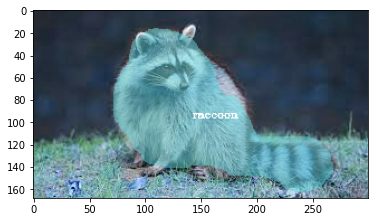

In [ ]:
# test a single image
!wget https://i.imgur.com/T5v5dFH.png -O ./demo/raccoon.jpg
img = 'demo/raccoon.jpg'
result = inference_detector(model, img)

# show the results
image = show_result_ins(img, result, model.CLASSES, score_thr=0.25, out_file=None)
plt.imshow(image)